# PortfolioCreator – Dalio's Uncorrelated Portfolio Recommender

This notebook builds on the previous analysis of return correlations to construct a **portfolio recommender** inspired by Ray Dalio's concept of combining uncorrelated return streams.

## High-level steps

1. Define the investment universe (liquid assets across major asset classes).
2. Load and preprocess historical price data.
3. Convert prices to returns and analyze correlations / clusters.
4. Select a diversified subset of assets based on liquidity and (low) correlation.
5. Use a portfolio optimization framework to propose recommended allocations.
6. Evaluate risk and performance characteristics of the recommended portfolio.

## 0. Setup and imports

In this section we import the required libraries (pandas, numpy, yfinance, riskfolio, plotting libraries, etc.) and configure basic plotting/style options to keep the visual outputs consistent with the previous notebook.

In [1]:
# Imports will mirror those in the previous notebook and add any extras needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import yfinance as yf
import riskfolio as rp

from datetime import datetime

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("PortfolioCreator notebook – environment ready")
print(f"Started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

PortfolioCreator notebook – environment ready
Started at: 2026-01-28 11:33:35


## 1. Define the liquid asset universe

We now define a broader universe of **highly liquid assets** spanning:

- Major equity indices and large-cap stocks
- Fixed income / bond ETFs
- Real assets (e.g., gold, commodities)
- Crypto assets (e.g., BTC, ETH)

The idea is to give the recommender a rich menu of liquid instruments from which to pick relatively uncorrelated building blocks, in line with Dalio's philosophy of combining multiple independent return streams.

The original idea was to fetch all assets and the filter by volume, but this is not feasable. 

So instead we are going to do some research and find the biggest (Market Cap) & voluminous (Daily Volume) assets

Find how I picked these assets in the **research** folder

In [ ]:
# Placeholder: define a list of tickers representing a broader liquid universe
# (Can be customized/expanded later)

universe = [
    # Equities
    "SPY",   # US equities
    "VEA",   # Developed ex-US
    "EEM",   # Emerging markets

    # Bonds
    "TLT",   # Long-term treasuries
    "IEF",   # Intermediate treasuries
    "LQD",   # Investment grade credit
    "HYG",   # High yield

    # Commodities
    "GLD",   # Gold
    "DBC",   # Broad commodities
    "USO",   # Oil

    # Inflation / Real assets
    "VNQ",   # REITs
    "TIP",   # Inflation-linked bonds

    # Cash proxy
    "SHY",

    # Crypto
    "BTC-USD",
    
    "ETH-USD"
]


print(f"Universe size: {len(universe)} assets")

Universe size: 12 assets


## 2. Load and preprocess historical data

We fetch (or load cached) historical price data for the defined universe:

- Use `Adj Close` prices to incorporate dividends and corporate actions.
- Align all assets on a common date index.
- Optionally restrict to a recent window (e.g., last 3–5 years) to focus on a relevant regime.

This mirrors the data preparation in the earlier notebook but scales it to a larger universe suitable for a recommender.

In [ ]:
# Placeholder for data loading logic – can reuse CSV cache logic from the first notebook

start_date = "2020-01-01"
end_date = "2026-01-01"

csv_path = "data/portfolio_creator_universe.csv"

if os.path.exists(csv_path):
    prices = pd.read_csv(csv_path, index_col=0, parse_dates=True)
else:
    data = yf.download(universe, start=start_date, end=end_date, auto_adjust=False)
    prices = data["Adj Close"] if isinstance(data.columns, pd.MultiIndex) else data
    os.makedirs(os.path.dirname(csv_path), exist_ok=True)
    prices.to_csv(csv_path)

prices

[*********************100%***********************]  12 of 12 completed


Ticker,BTC-USD,DBC,ETH-USD,GLD,IEF,IWM,QQQ,SPY,TLT,XLF,XLK,XLV
Date,,,,,,,,,,,,
2018-01-01,13657.200195,NaN,772.640991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02,14982.099609,14.110355,884.443970,125.150002,87.510490,139.131439,150.411591,237.208252,100.572472,24.006914,29.910076,73.022308
2018-01-03,15201.000000,14.194898,962.719971,124.820000,87.601921,139.276154,151.873016,238.708618,101.053352,24.135893,30.159555,73.720993
2018-01-04,15599.200195,14.177990,980.921997,125.459999,87.560371,139.646744,152.138824,239.714691,101.037354,24.359451,30.312006,73.825806
2018-01-05,17429.500000,14.127261,997.719971,125.330002,87.452293,139.936066,153.666702,241.312225,100.748840,24.428238,30.630791,74.454620
...,...,...,...,...,...,...,...,...,...,...,...,...
2026-01-23,89503.875000,24.180000,2953.256348,458.000000,95.949997,264.809998,622.719971,689.229980,87.930000,53.070000,145.089996,157.479996
2026-01-24,89110.734375,NaN,2948.740723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2026-01-25,86572.218750,NaN,2815.902344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Convert prices to returns and analyze correlations

We convert prices to daily percentage returns and inspect:

- Basic summary statistics (median, mean, volatility).
- The correlation matrix and hierarchical clustering structure.

This step identifies groups of assets that tend to move together and, more importantly, assets (or clusters) that behave differently from one another, which is key to building uncorrelated portfolios.

In [4]:
returns = prices.pct_change().dropna()

# Quick sanity checks
summary_stats = pd.DataFrame({
    "mean": returns.mean(),
    "median": returns.median(),
    "vol": returns.std()
})

summary_stats.sort_values("vol", ascending=False)

/var/folders/jn/y5sznyds3jn3gnk2zpy70gj80000gn/T/ipykernel_88953/3421253773.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change().dropna()


,mean,median,vol
Ticker,,,
ETH-USD,0.001410,0.000588,0.044257
BTC-USD,0.001181,0.000735,0.033731
XLK,0.000637,0.000000,0.013717
IWM,0.000301,0.000000,0.012823
QQQ,0.000565,0.000000,0.012533
XLF,0.000345,0.000000,0.012314
SPY,0.000417,0.000000,0.010140
DBC,0.000234,0.000000,0.009450
XLV,0.000298,0.000000,0.009152


<Axes: >

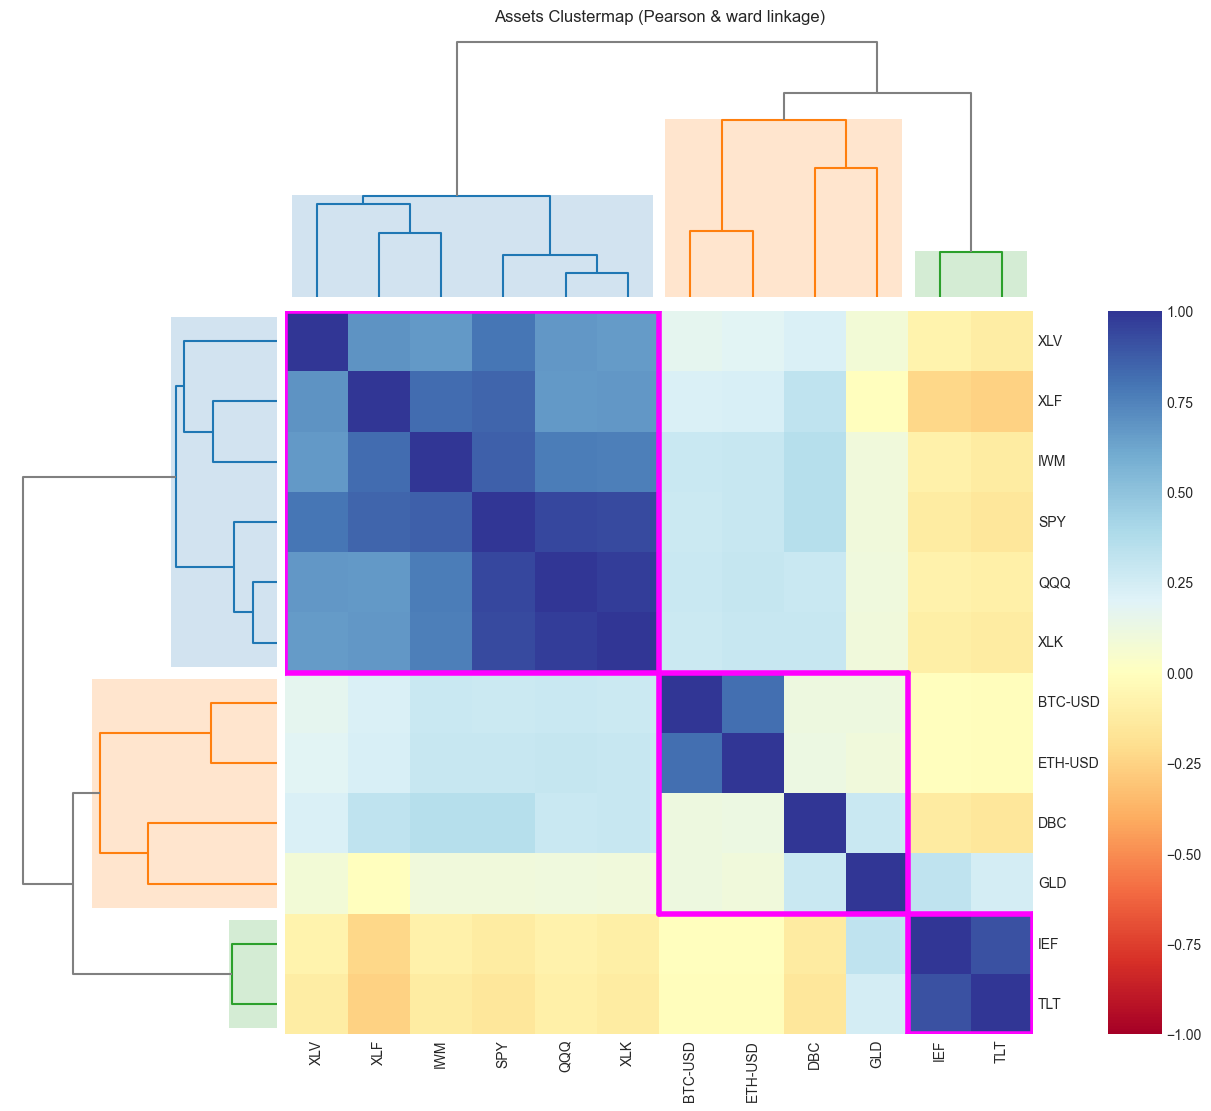

In [5]:
# Visualize correlation clusters (similar to the first notebook)

ax = rp.plot_clusters(
    returns=returns,
    codependence="pearson",
    linkage="ward",
    k=None,
    max_k=10,
    leaf_order=True,
    ax=None
)
ax

## 4. Select assets for the Dalio-style portfolio

Based on the correlation clusters and basic liquidity/volatility filters, we select a subset of assets to include in the portfolio recommender:

- Favor assets that are **highly liquid** (tight spreads, large trading volumes).
- Avoid redundant assets that are nearly perfectly correlated with others in the same cluster.
- Ensure that the final set includes **multiple, distinct clusters** of return behavior.

This yields a smaller, more interpretable set of building blocks to pass into the optimizer.

In [6]:
# Placeholder: simple selection rule (to be refined)
# For now, we keep all assets; later, we can plug in
# volume filters and cluster-based pruning.

selected_assets = list(returns.columns)

print("Selected assets for portfolio optimization:")
print(selected_assets)

selected_returns = returns[selected_assets]

Selected assets for portfolio optimization:
['BTC-USD', 'DBC', 'ETH-USD', 'GLD', 'IEF', 'IWM', 'QQQ', 'SPY', 'TLT', 'XLF', 'XLK', 'XLV']


## 5. Build the portfolio recommender (optimization)

With the selected return series, we now set up a **portfolio optimization problem** using `riskfolio`:

- Specify constraints (long-only, max/min weights, optional cash position).
- Choose an objective (e.g., maximize Sharpe ratio, minimize risk for a target return).
- Incorporate **correlation / co-dependence structure** so that the optimizer favors combinations of assets that diversify each other.

The output of this step will be a **recommended allocation vector** over the selected assets.

In [7]:
# Placeholder for riskfolio portfolio optimization setup

Y = selected_returns

# Example skeleton (to be filled in with specific choices):
# port = rp.Portfolio(returns=Y)
# port.assets_stats(method_mu="hist", method_cov="hist")
# model = "Classic"         # or, e.g., "FM" for factor model
# rm = "MV"                 # risk measure, e.g., mean-variance
# obj = "Sharpe"            # objective: maximize Sharpe ratio
# hist = True
# w = port.optimization(model=model, rm=rm, obj=obj, hist=hist)
# w

# For now, just inspect the prepared returns matrix
Y.head()

Ticker,BTC-USD,DBC,ETH-USD,GLD,IEF,IWM,QQQ,SPY,TLT,XLF,XLK,XLV
Date,,,,,,,,,,,,
2018-01-03,0.014611,0.005992,0.088503,-0.002637,0.001045,0.001040,0.009716,0.006325,0.004781,0.005373,0.008341,0.009568
2018-01-04,0.026196,-0.001191,0.018907,0.005127,-0.000474,0.002661,0.001750,0.004215,-0.000158,0.009262,0.005055,0.001422
2018-01-05,0.117333,-0.003578,0.017125,-0.001036,-0.001234,0.002072,0.010043,0.006664,-0.002856,0.002824,0.010517,0.008518
2018-01-06,0.005594,0.000000,0.044061,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-01-07,-0.059873,0.000000,0.107029,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## 6. Evaluate and interpret the recommended portfolio

Once the optimizer is configured and run, we will:

- Visualize the recommended weights across assets and clusters.
- Compute key risk and performance metrics (volatility, Sharpe ratio, max drawdown, etc.).
- Discuss how the resulting portfolio reflects Dalio's principle of combining **many uncorrelated bets** rather than concentrating risk in a single asset class.

This section will translate the raw optimization output into intuitive insights for an investor or portfolio manager.

## 7. Next steps and extensions

Possible extensions to this notebook include:

- Incorporating **transaction costs and turnover constraints** into the optimization.
- Allowing for **user-specific preferences** (risk tolerance, target volatility, exclusion lists).
- Testing robustness across different historical windows and market regimes.
- Extending the universe to include **global assets** (international equities, FX, more commodities).

These enhancements would bring the PortfolioCreator closer to a production-ready, Dalio-inspired portfolio construction tool.